Todos1:
* load dataset and embeddings - done
* create model and train - done
* show result auc roc, recall, pression, training hystory - done
* add dataset statistics/description
* add embedings explanation
* add neural nework explanations(images, video)

* add false positive, true positive, false negative analisys (use mostly the same statistics as in the dataset statistics)
* write result/inference
* make experiments and save the result into google drive file
> **Experiments ([file](https://docs.google.com/spreadsheets/d/1VnfjCM5kayhn4BFC9Eng9UdKUIE_Ymgs4PdXzMw8fVM/edit?usp=sharing))**

In [ ]:
if (!require("keras")) install.packages("keras")
library(keras)
if (!require("tidyverse")) install.packages("tidyverse")
library(tidyverse)
if (!require("qdapRegex")) install.packages("qdapRegex")
library(qdapRegex)
if (!require("data.table")) install.packages("data.table")
library(data.table)
if (!require("caret")) install.packages("caret")
library(caret) 
library(ROCR)

In [ ]:

train_data = read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
test_data = read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")

max_words = 130000
maxl = 200

In [ ]:
wordseq = text_tokenizer(num_words = max_words) %>%
        fit_text_tokenizer(c(train_data$comment_text,test_data$comment_text))

In [ ]:
#word dictionary
word_index = wordseq$word_index

x_train = texts_to_sequences(wordseq, train_data$comment_text ) %>%
        pad_sequences( maxlen = maxl)
y_train = as.matrix(train_data[,3:8])

x_test = texts_to_sequences(wordseq, test_data$comment_text ) %>%
        pad_sequences( maxlen = maxl)

In [ ]:
wgt = fread("../input/glove840b300dtxt/glove.840B.300d.txt", data.table = FALSE)  %>%
        rename(word=V1)  %>%
        mutate(word=gsub("[[:punct:]]"," ", rm_white(word) ))

In [ ]:
#!For dataset description/statistics
#https://www.kaggle.com/amachno/word-frequencies -usefull vizualization
#https://www.kaggle.com/nulldata/identity-attack-poor-americans-pakistanis-germans
#https://www.kaggle.com/madcap/toxic-exploration --very good
#todo: show some stats about datasets and embedding distances

In [ ]:
#try to split into validation and train
# Shuffle observations   
set.seed(484)
indices <- sample(1:dim(x_train)[1])    
# Split into training and validation sample
prop_train <- .85
train_indices <- 1: round(prop_train*dim(x_train)[1], 0)
val_indices <-  (round(prop_train*dim(x_train)[1], 0)+1) : dim(x_train)[1]
    
x_tr <- x_train[indices[train_indices], ]    
y_tr <- y_train[indices[train_indices], ]
    
x_val <- x_train[indices[val_indices], ]    
y_val <-  y_train[indices[val_indices], ]
y_tr <- as.matrix(y_tr)
y_val <- as.matrix(y_val)

In [ ]:
text_val = train_data[indices[val_indices],]
head(text_val)

In [ ]:
dic_words = wgt$word
wordindex = unlist(wordseq$word_index)

dic = data.frame(word=names(wordindex), key = wordindex,row.names = NULL) %>%
        arrange(key) %>% 
        .[1:max_words,]

w_embed = dic %>% 
        left_join(wgt)

J = ncol(w_embed)
ndim = J-2
w_embed = w_embed [1:(max_words-1),3:J] %>%
        mutate_all(as.numeric) %>%
        mutate_all(round,6) %>%
        #fill na with 0
        mutate_all(funs(replace(., is.na(.), 0))) 

colnames(w_embed) = paste0("V",1:ndim)
w_embed = rbind(rep(0, ndim), w_embed) %>%
        as.matrix()

In [ ]:
w_embed = list(array(w_embed , c(max_words, ndim)))

**Embeddings**
![image.png](https://qph.fs.quoracdn.net/main-qimg-e8b83b14d7261d75754a92d0d3605e36)

Recurrent Neuronal Netowork
![image.png](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

LSTM
![lstm](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

Convolutional Neural Network
![image.png](https://image.slidesharecdn.com/dlsl2017d2l3recurrentneuralnetworksii-170125171005/95/recurrent-neural-networks-ii-d2l3-deep-learning-for-speech-and-language-upc-2017-12-638.jpg?cb=1485365099)

In [ ]:
inp = layer_input(shape = list(maxl),
                  dtype = "int32", name = "input")
emm = inp %>%
        layer_embedding(input_dim = max_words, output_dim = ndim, input_length = maxl, weights = w_embed, trainable=FALSE) 
model = emm %>%
        layer_spatial_dropout_1d(rate=0.1) %>%
        bidirectional( #hyperparameter: how many layers
                layer_gru(units = 40, #hyperparameter
                          return_sequences = TRUE, 
                          recurrent_dropout = 0.1) 
        )# %>% 
#        layer_conv_1d( #hyperparameter: how many layers
#            60, #hyperparameter
#            3, #hyperparameter
#            padding = "valid",
#            activation = "relu",
#            strides = 1
#          ) 

max_pool = model %>% layer_global_max_pooling_1d()
ave_pool = model %>% layer_global_average_pooling_1d()

outp = layer_concatenate(list(ave_pool, max_pool)) %>%
        layer_dense(units = 6, activation = "sigmoid")

model = keras_model(inp, outp)

model %>% compile(
        optimizer = "adam",
        loss = "binary_crossentropy",
        metrics = c("acc")
)

**Binary cross entropy**
![image.png](https://cdn-images-1.medium.com/max/1164/1*PK0iVgkQepmVCprtTgbsGg.png)

In [ ]:
history = model %>% fit(
        x_tr, y_tr,
        epochs = 2,
        batch_size = 32,
        #validation_split = 0.05,
        validation_data = list(x_val,y_val),
        callbacks = list(
                callback_model_checkpoint(paste0("toxic_comment_model.h5"), save_best_only = TRUE),
                callback_early_stopping(monitor = "val_loss", min_delta = 0, patience = 0,
                                        verbose = 0, mode = c("auto", "min", "max"))
        )
)

In [ ]:
model = load_model_hdf5(paste0("toxic_comment_model.h5"))
yhat_val  = model %>%
        predict(x_val, batch_size = 1024) %>%
        as.data.frame()
print(dim(yhat_val))

In [ ]:
y_yval = as.data.frame(y_val) #data frame
th = 0.5#the threshhold, if bigger take as prediction
classid = 1
#head(text_val[which(y_yval[1]>th),])#true toxic comments
#head(text_val[which(yhat_val[1]>th),])#predicted toxic comments
head(text_val[which(yhat_val[classid]>th & y_yval[classid]<th),])#predicted but not toxic comments

In [ ]:
head(text_val[which(yhat_val[classid]<th & y_yval[classid]>th),])#not predicted but toxic comments

In [ ]:
head(text_val[which(yhat_val[classid]>th & y_yval[classid]>th),])# predicted and true toxic comments

In [ ]:
plot(history)

In [ ]:
aucrocResults <- function(y,y_,classes){
    i <- 1
    auct <- 0
    for(cl in classes){
        pred <- prediction(y[i], y_[i])#just first prediction
        perf <- performance(pred, measure = "tpr", x.measure = "fpr")
        # I know, the following code is bizarre. Just go with it.
        auc <- performance(pred, measure = "auc")
        auc <- auc@y.values[[1]]        
        print(c(i, cl, auc))
        auct <- auct + auc
        i <- i + 1
    }
    print(c("total",auct/(i-1)))
}
classes = c("toxic", "severe_toxic", "obscene", "threat","insult", "identity_hate")
aucrocResults(yhat_val, y_yval, classes)#save the output into the spreadsheet on google drive!!!

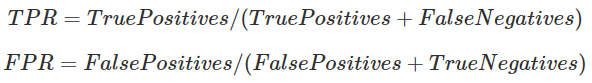

In [ ]:
cl = classid2
pred <- prediction(yhat_val[cl], y_yval[cl])#just first class
perf <- performance(pred, measure = "tpr", x.measure = "fpr")
# I know, the following code is bizarre. Just go with it.
auc <- performance(pred, measure = "auc")
auc <- auc@y.values[[1]]

roc.data <- data.frame(fpr=unlist(perf@x.values),
 tpr=unlist(perf@y.values),
 model="GLM")
ggplot(roc.data, aes(x=fpr, ymin=0, ymax=tpr)) +
 geom_ribbon(alpha=0.2) +
 geom_line(aes(y=tpr)) +
 ggtitle(paste0(classes[cl]," : ROC Curve w/ AUC=", auc))#todo: make subplots for each class!
#https://community.alteryx.com/t5/Data-Science-Blog/ROC-Curves-in-Python-and-R/ba-p/138430 --explanations about auc roc